In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [3]:
img = cv2.imread('./window.jpeg') # numpy array
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
blur = cv2.GaussianBlur(gray, (5,5), 1)

In [5]:
# Add Gaussian Noise
def add_noise(image, mean, sigma):
    gaussian = np.random.normal(mean, sigma, (image.shape[0],image.shape[1])) 
    noisy_img = image + gaussian
    cv2.normalize(noisy_img, noisy_img, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img

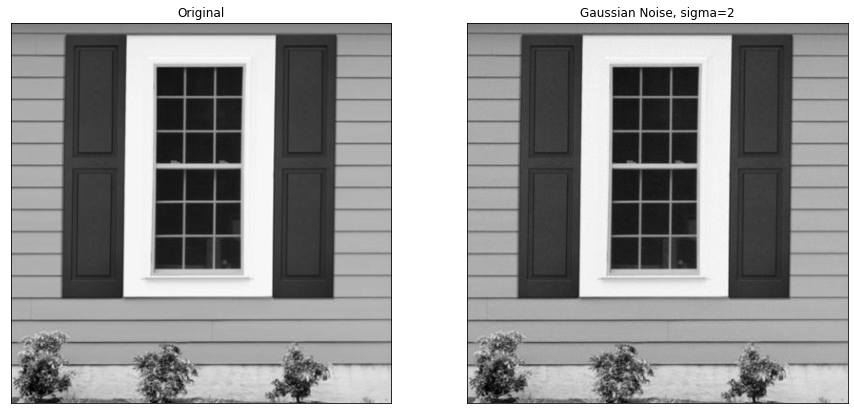

In [6]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(gray,cmap = 'gray')
ax1.title.set_text('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(add_noise(gray, 0, 2),cmap = 'gray')
ax2.title.set_text('Gaussian Noise, sigma=2'), ax2.set_xticks([]), ax2.set_yticks([]);

(None, [], [])

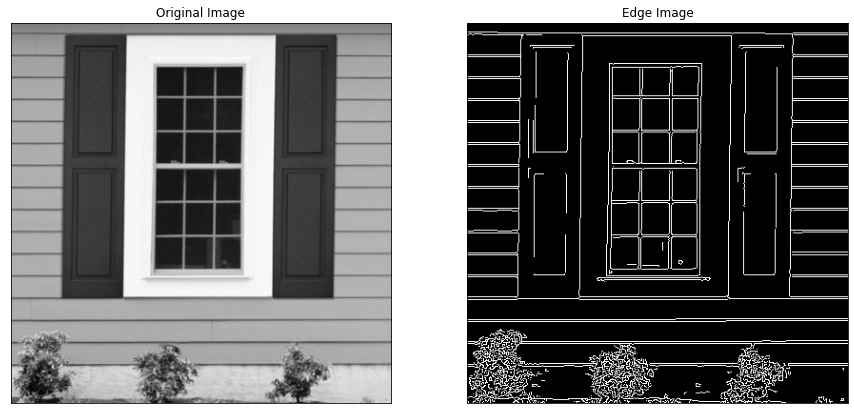

In [7]:
# No noise for reference

edges = cv2.Canny(gray, threshold1=75, threshold2=100)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(gray, cmap = 'gray')
ax1.title.set_text('Original Image'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(edges,cmap = 'gray')
ax2.title.set_text('Edge Image'), ax2.set_xticks([]), ax2.set_yticks([])

(None, [], [])

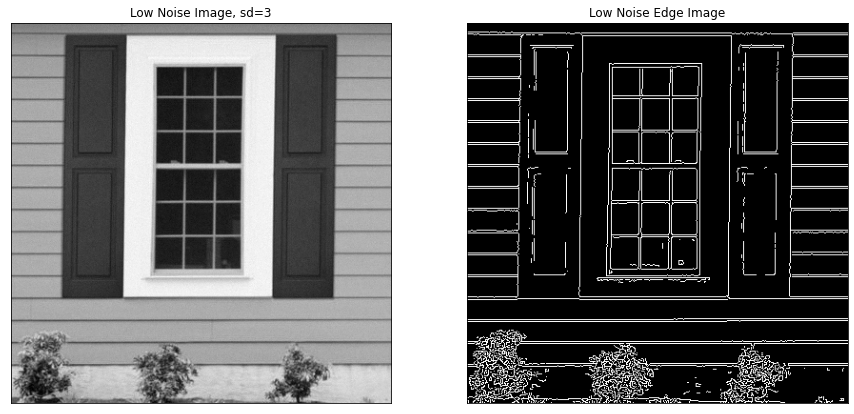

In [8]:
low_noise = add_noise(gray, 0, 3)

edges = cv2.Canny(low_noise, threshold1=75, threshold2=100)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(low_noise, cmap = 'gray')
ax1.title.set_text('Low Noise Image, sd=3'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(edges,cmap = 'gray')
ax2.title.set_text('Low Noise Edge Image'), ax2.set_xticks([]), ax2.set_yticks([])

(None, [], [])

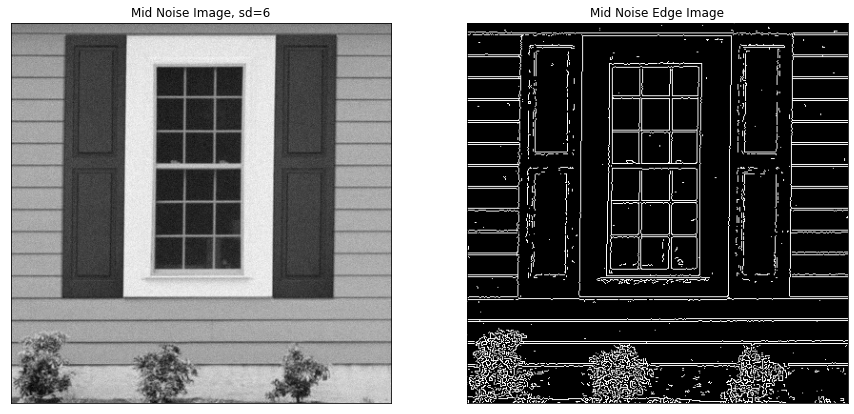

In [9]:
mid_noise = add_noise(gray, 0, 6)

edges = cv2.Canny(mid_noise, threshold1=75, threshold2=100)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(mid_noise, cmap = 'gray')
ax1.title.set_text('Mid Noise Image, sd=6'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(edges,cmap = 'gray')
ax2.title.set_text('Mid Noise Edge Image'), ax2.set_xticks([]), ax2.set_yticks([])

(None, [], [])

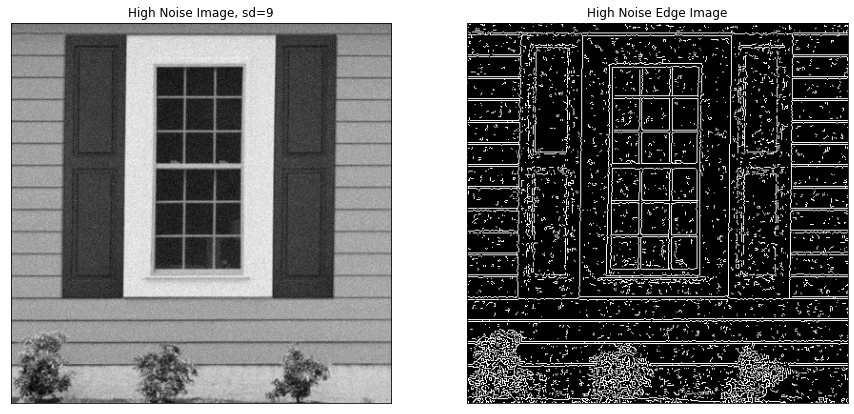

In [10]:
high_noise = add_noise(gray, 0, 9)

edges = cv2.Canny(high_noise, threshold1=75, threshold2=100)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(high_noise, cmap = 'gray')
ax1.title.set_text('High Noise Image, sd=9'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(edges,cmap = 'gray')
ax2.title.set_text('High Noise Edge Image'), ax2.set_xticks([]), ax2.set_yticks([])

**Conclusion**: More detailed edges in the low blur, less in mid, but it seems like we get roughly the same number of edges as the high blur image. Moreover, the edges in the high blur image seems a lot straighter, indicating that noise close to the edges have been blurred out.

## Edge Detection

In [11]:
test_img = cv2.imread('./image.png')
gray_test = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

In [12]:
# Gaussian kernels are separable (proof in report), so its sufficient to create the k-length array,
# then take outer products.

# Mean = 0

def getGaussianKernel(size, var):
    unnormalizedKer = np.array(
        [np.exp(-(i-(size-1)/2)**2/(2*var**2)) for i in range(size)]
    )
    norm_const = unnormalizedKer.sum()
    ker = unnormalizedKer / norm_const
    return np.outer(ker, ker)

In [13]:
kernel = getGaussianKernel(100, 10)

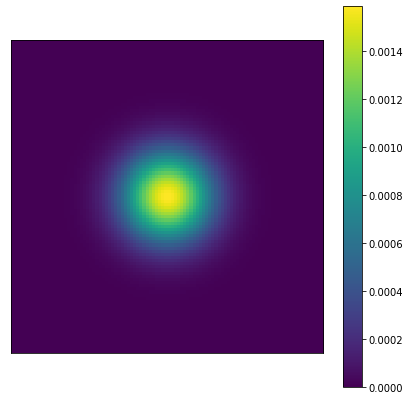

In [14]:
plt.figure(figsize=(7, 7))
plt.imshow(kernel)
plt.xticks([]), plt.yticks([]);
plt.colorbar()

In [15]:
kernel = getGaussianKernel(100,20)

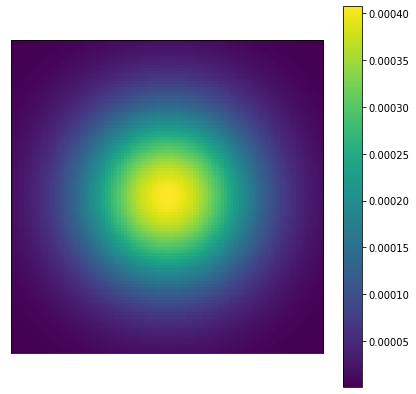

In [16]:
plt.figure(figsize=(7, 7))
plt.imshow(kernel)
plt.xticks([]), plt.yticks([]);
plt.colorbar()

In [17]:
# x-grad and y-grad matrices
gx = np.array([[-1, 0, 1],
             [-2, 0, 2],
             [-1, 0, 1]])
gy = gx.transpose()
gx, gy

(array([[-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]]),
 array([[-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]]))

In [18]:
def convolve(I, F):
    res = np.zeros(I.shape, dtype="float32")
    pad_row, pad_col = F.shape
    pad_row //= 2
    pad_col //= 2
    padded = np.pad(I, ((pad_col,), (pad_row,)), 'constant', constant_values=0)
    F_flipped = np.flip(F, (0, 1)) # flips along horizontal and vertical axes

    for x in range(pad_col, I.shape[1] + pad_col):
        for y in range(pad_row, I.shape[0] + pad_row):
            reg = padded[y - pad_row : y + pad_row + 1, x - pad_col : x + pad_col + 1]
            G = (reg * F_flipped).sum()
            res[y - pad_row, x - pad_col] = G
            
    return res

In [19]:
convolve(np.ones(25).reshape((5,5)), np.arange(9).reshape((3,3)))

array([[ 8., 15., 15., 15., 12.],
       [21., 36., 36., 36., 27.],
       [21., 36., 36., 36., 27.],
       [21., 36., 36., 36., 27.],
       [20., 33., 33., 33., 24.]], dtype=float32)

(None, [], [])

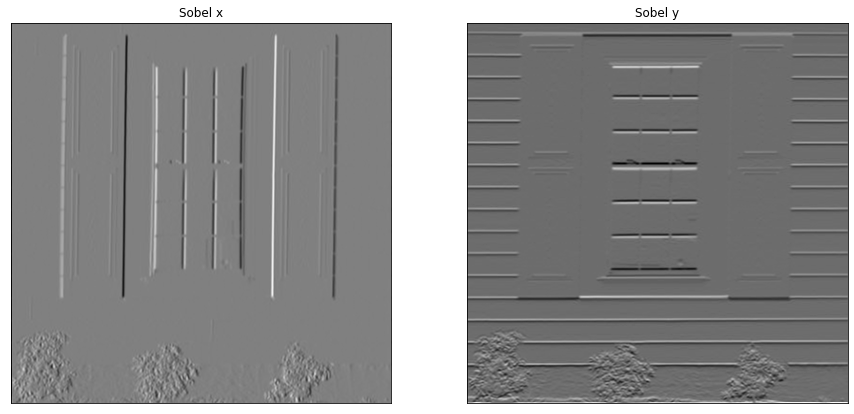

In [20]:
G = np.power( np.power(convolve(gray, gx), 2) + np.power(convolve(gray, gy), 2), 0.5 )
sobelx = convolve(gray, gx)
sobely = convolve(gray, gy)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(sobelx, cmap = 'gray')
ax1.title.set_text('Sobel x'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(sobely, cmap = 'gray')
ax2.title.set_text('Sobel y'), ax2.set_xticks([]), ax2.set_yticks([])

In [56]:
cat_img = cv2.imread('./cat.jpg')
gray_cat = cv2.cvtColor(cat_img, cv2.COLOR_BGR2GRAY)

(None, [], [])

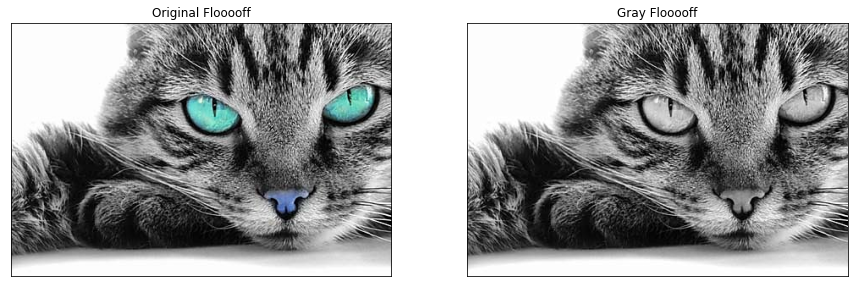

In [69]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(cat_img)
ax1.title.set_text('Original Flooooff'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(gray_cat, cmap = 'gray')
ax2.title.set_text('Gray Flooooff'), ax2.set_xticks([]), ax2.set_yticks([])

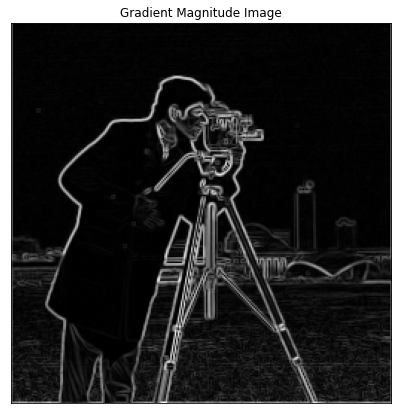

In [44]:
plt.figure(figsize=(7, 7))
G_cam = np.power( np.power(convolve(gray_test, gx), 2) + np.power(convolve(gray_test, gy), 2), 0.5 )
plt.imshow(G_cam, cmap= 'gray'), plt.title("Gradient Magnitude Image")
plt.xticks([]), plt.yticks([]);

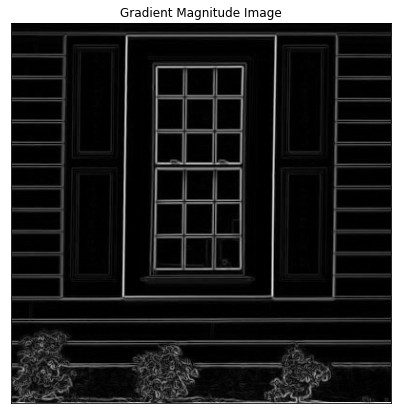

In [45]:
plt.figure(figsize=(7, 7))
plt.imshow(G, cmap= 'gray')
plt.title("Gradient Magnitude Image")
plt.xticks([]), plt.yticks([]);

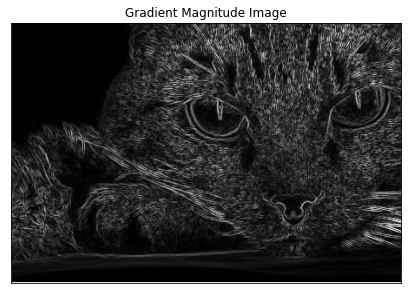

In [58]:
G_cat = np.power( np.power(convolve(gray_cat, gx), 2) + np.power(convolve(gray_cat, gy), 2), 0.5 )
plt.figure(figsize=(7, 7))
plt.imshow(G_cat, cmap= 'gray')
plt.title("Gradient Magnitude Image")
plt.xticks([]), plt.yticks([]);

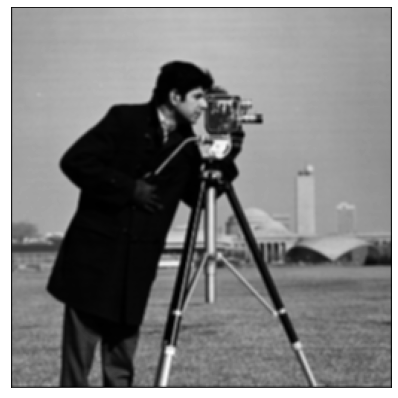

In [31]:
plt.figure(figsize=(7, 7))
blur_test = convolve(gray_test, getGaussianKernel(3, 1))
plt.imshow(blur_test, cmap= 'gray')
plt.xticks([]), plt.yticks([]);

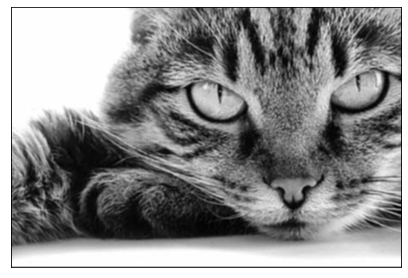

In [70]:
plt.figure(figsize=(7, 7))
blur_test = convolve(gray_cat, getGaussianKernel(3, 1))
plt.imshow(blur_test, cmap= 'gray')
plt.xticks([]), plt.yticks([]);

In [50]:
def pipeline(img):
    img = convolve(img, getGaussianKernel(3, 1))
    G = np.power( np.power(convolve(img, gx), 2) + np.power(convolve(img, gy), 2), 0.5 )
    e = 0.1
    t = G.sum() / (G.shape[0] * G.shape[1])
    tprev = None
    i = 0
    
    while tprev is None or abs(t - tprev) > e:
#         below = G < t
#         rest = np.logical_not(below)
#         ml = np.mean(G * below)
#         mh = np.mean(G * rest)
        below = G[G < t]
        rest = G[G >= t]
        ml = np.mean(below)
        mh = np.mean(rest)
        i += 1
        tprev = t
        t = (ml + mh) / 2
        # if i > 20: break
    print(t, ml, mh)
    edges = np.where(G >= t, 255, 0)
    return edges

190.72027587890625 29.012537 352.428


(None, [], [])

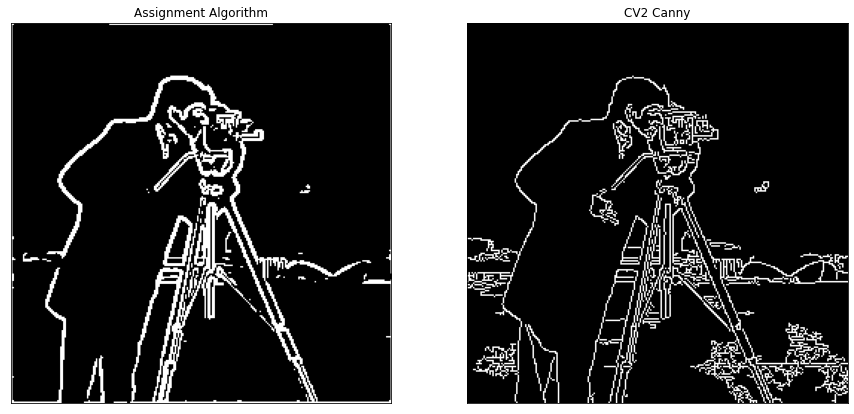

In [78]:
alg_cam = pipeline(gray_test)
dst = cv2.filter2D(gray_test, ddepth=cv2.CV_8U, kernel=cv2.getGaussianKernel(5, 1))
canny = cv2.Canny(gray_test, 37, 370)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(alg_cam, cmap='gray')
ax1.title.set_text('Assignment Algorithm'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(canny, cmap = 'gray')
ax2.title.set_text('CV2 Canny'), ax2.set_xticks([]), ax2.set_yticks([])

175.25546264648438 63.258377 287.25256


(None, [], [])

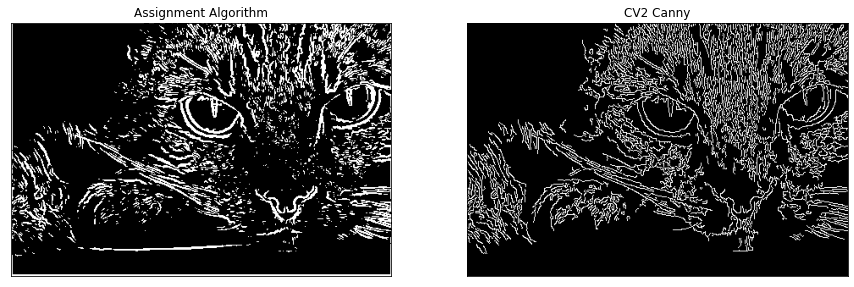

In [79]:
alg_cat = pipeline(gray_cat)
dst = cv2.filter2D(gray_cat, ddepth=cv2.CV_8U, kernel=cv2.getGaussianKernel(5, 1))
canny = cv2.Canny(dst, 140, 290)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(alg_cat, cmap='gray')
ax1.title.set_text('Assignment Algorithm'), ax1.set_xticks([]), ax1.set_yticks([])
ax2.imshow(canny, cmap = 'gray')
ax2.title.set_text('CV2 Canny'), ax2.set_xticks([]), ax2.set_yticks([])